In [1]:
import os
os.environ["PYTHON_PYSPARK"] = "python"

making pyspark session 

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark Analysis of Flying Etiquette Survey Data").getOrCreate()

Part a) Frequency of Air Travel
Write PySpark code to:

Load the "flying.csv" dataset using PySpark
Construct a horizontal bar chart of the frequency variable (answers to "How often do you travel by plane?")
Include a suitable title and proper axis labels
Display the counts in descending order
Requirements:

Include your PySpark code
Include the resulting bar chart
Briefly describe the distribution of travel frequency among respondents

load the dataset


In [3]:
spark_data = spark.read.csv('flying_1671498679775.csv', header=True, inferSchema=True)
spark_data.show(5)

+------+-----+-----------------+-------------------+--------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+-----------+
|gender|  age|children_under_18|   household_income|           frequency|  recline_frequency|recline_obligation|recline_rude|recline_eliminate|switch_seats_friends|switch_seats_family|wake_up_bathroom|wake_up_walk|    baby|unruly_child|       two_arm_rests|     middle_arm_rest|               shade|unsold_seat|talk_stranger|     get_up|
+------+-----+-----------------+-------------------+--------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------

In [4]:
print("counting the rows: ", spark_data.count())
print("checking the column: ", len(spark_data.columns))

counting the rows:  1007
checking the column:  21


In [5]:
from pyspark.sql.functions import col
freq_counts = spark_data.groupBy("frequency")\
  .count()\
    .orderBy(col("count").desc())

freq_counts.show()


+--------------------+-----+
|           frequency|count|
+--------------------+-----+
| Once a year or less|  611|
|Once a month or less|  198|
|               Never|  164|
|A few times per m...|   29|
|           Every day|    3|
|A few times per week|    2|
+--------------------+-----+



converting to pandas dataframe

In [6]:
pdf= freq_counts.toPandas()
pdf.head(5)


,frequency,count
0,Once a year or less,611
1,Once a month or less,198
2,Never,164
3,A few times per month,29
4,Every day,3


plotting the Frequency of Air Travel

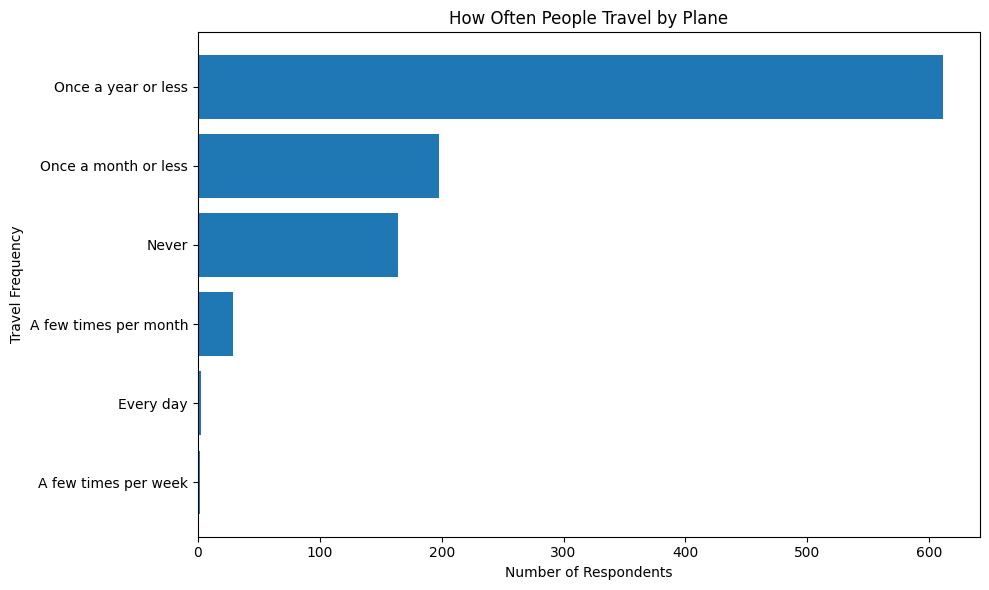

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(pdf["frequency"], pdf["count"])

plt.xlabel("Number of Respondents")
plt.ylabel("Travel Frequency")
plt.title("How Often People Travel by Plane")

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


Part b) Children and Attitudes Toward Babies on Planes
Consider the variables:

children_under_18 (answers to "Do you have any children under 18?")
baby (answers to "In general, is it rude to bring a baby on a plane?")
Write PySpark code to:

Remove any rows where either of these two variables is null
Construct an appropriate graphical plot showing the relationship between the two variables (e.g., grouped bar chart, stacked bar chart, or cross-tabulation visualization)
Include your PySpark code, graphical plot, and a written conclusion
Questions to address in your conclusion:

What is the relationship between having children under 18 and attitudes toward babies on planes?
Do parents and non-parents have significantly different views?
What patterns or trends do you observe?

Part b) Children and Attitudes Toward Babies on Planes

In [8]:
columns_to_check = [
    "gender", "age", "children_under_18", "household_income", "frequency", 
    "recline_frequency", "recline_obligation", "recline_rude", "recline_eliminate",
    "switch_seats_friends", "switch_seats_family", "wake_up_bathroom", "wake_up_walk", 
    "baby", "unruly_child", "two_arm_rests", "middle_arm_rest", "shade", 
    "unsold_seat", "talk_stranger", "get_up"
]


from pyspark.sql.functions import col, sum as sum

null_counts = spark_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_check])

null_counts.show()



+------+---+-----------------+----------------+---------+-----------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+----+------------+-------------+---------------+-----+-----------+-------------+------+
|gender|age|children_under_18|household_income|frequency|recline_frequency|recline_obligation|recline_rude|recline_eliminate|switch_seats_friends|switch_seats_family|wake_up_bathroom|wake_up_walk|baby|unruly_child|two_arm_rests|middle_arm_rest|shade|unsold_seat|talk_stranger|get_up|
+------+---+-----------------+----------------+---------+-----------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+----+------------+-------------+---------------+-----+-----------+-------------+------+
|     0|  0|                0|               0|        0|                0|                 0|           0|                0|                   0|  

In [9]:
df_clean = spark_data.dropna(subset=["children_under_18", "baby"])
df_clean.show(2)


+------+-----+-----------------+-------------------+-------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+-----------+
|gender|  age|children_under_18|   household_income|          frequency|  recline_frequency|recline_obligation|recline_rude|recline_eliminate|switch_seats_friends|switch_seats_family|wake_up_bathroom|wake_up_walk|    baby|unruly_child|       two_arm_rests|     middle_arm_rest|               shade|unsold_seat|talk_stranger|     get_up|
+------+-----+-----------------+-------------------+-------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+--

In [10]:
cross_tab = (
    df_clean
    .groupBy("children_under_18", "baby")
    .count()
    .orderBy("children_under_18", "baby")
)

cross_tab.show()


+-----------------+--------+-----+
|children_under_18|    baby|count|
+-----------------+--------+-----+
|            FALSE|      No|  428|
|            FALSE|Somewhat|  157|
|            FALSE|    Very|   67|
|               NA|      NA|  164|
|               NA|      No|    2|
|               NA|Somewhat|    1|
|               NA|    Very|    1|
|             TRUE|      No|  157|
|             TRUE|Somewhat|   23|
|             TRUE|    Very|    7|
+-----------------+--------+-----+



In [11]:
pdf = cross_tab.toPandas()


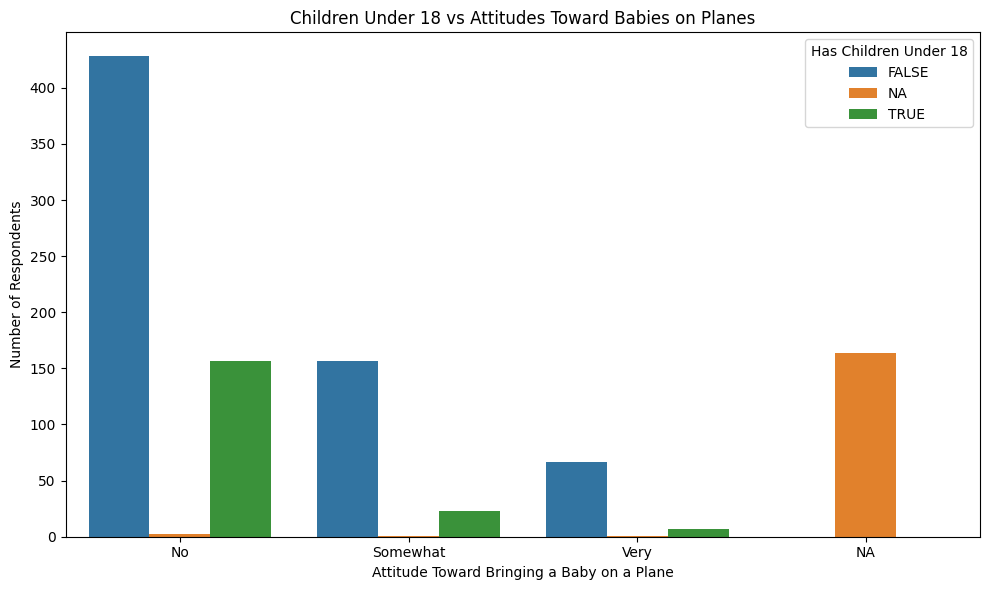

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(
    data=pdf,
    x="baby",
    y="count",
    hue="children_under_18"
)

plt.xlabel("Attitude Toward Bringing a Baby on a Plane")
plt.ylabel("Number of Respondents")
plt.title("Children Under 18 vs Attitudes Toward Babies on Planes")
plt.legend(title="Has Children Under 18")

plt.tight_layout()
plt.show()


Part c) Age Groups and Reclining Seats Behavior
Consider the variables:

age (respondent's age group)
recline (answers to "Is it rude to recline your seat on a plane?")
Write PySpark code to:

Filter out any rows with null values in either variable
Create a contingency table showing the relationship between age groups and opinions on reclining seats
Calculate the percentage of respondents in each age group who think it is rude to recline
Create a grouped or faceted bar chart displaying these percentages by age group
Interpret your findings: Which age groups are most likely to consider seat reclining rude? Is there a clear trend?
Include in your answer: PySpark code, contingency table, percentage calculations, visualization, and interpretation.

In [13]:
df_clean = spark_data.dropna(subset=["age", "recline_rude"])
df_clean.show(2)


+------+-----+-----------------+-------------------+-------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+-----------+
|gender|  age|children_under_18|   household_income|          frequency|  recline_frequency|recline_obligation|recline_rude|recline_eliminate|switch_seats_friends|switch_seats_family|wake_up_bathroom|wake_up_walk|    baby|unruly_child|       two_arm_rests|     middle_arm_rest|               shade|unsold_seat|talk_stranger|     get_up|
+------+-----+-----------------+-------------------+-------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+--

In [14]:
contingency = (
    df_clean
    .groupBy("age", "recline_rude")
    .count()
    .orderBy("age", "recline_rude")
)

contingency.show()


+-----+------------+-----+
|  age|recline_rude|count|
+-----+------------+-----+
|18-29|          NA|   48|
|18-29|          No|   78|
|18-29|    Somewhat|   74|
|18-29|        Very|   20|
|30-44|          NA|   32|
|30-44|          No|  143|
|30-44|    Somewhat|   64|
|30-44|        Very|   15|
|45-60|          NA|   41|
|45-60|          No|  140|
|45-60|    Somewhat|   80|
|45-60|        Very|   14|
| > 60|          NA|   43|
| > 60|          No|  133|
| > 60|    Somewhat|   61|
| > 60|        Very|   21|
+-----+------------+-----+



In [15]:
from pyspark.sql.functions import col

total_per_age = (
    df_clean
    .groupBy("age")
    .count()
    .withColumnRenamed("count", "total")
)

very_rude = (
    df_clean
    .filter(col("recline_rude") == "Very")
    .groupBy("age")
    .count()
    .withColumnRenamed("count", "very_rude_count")
)


percentage_df = (
    total_per_age
    .join(very_rude, on="age", how="left")
    .fillna(0)
    .withColumn(
        "percentage_very_rude",
        (col("very_rude_count") / col("total")) * 100
    )
)

percentage_df.show()


+-----+-----+---------------+--------------------+
|  age|total|very_rude_count|percentage_very_rude|
+-----+-----+---------------+--------------------+
|45-60|  275|             14|   5.090909090909091|
|30-44|  254|             15|   5.905511811023622|
|18-29|  220|             20|   9.090909090909092|
| > 60|  258|             21|    8.13953488372093|
+-----+-----+---------------+--------------------+



In [16]:
pdf = percentage_df.toPandas()


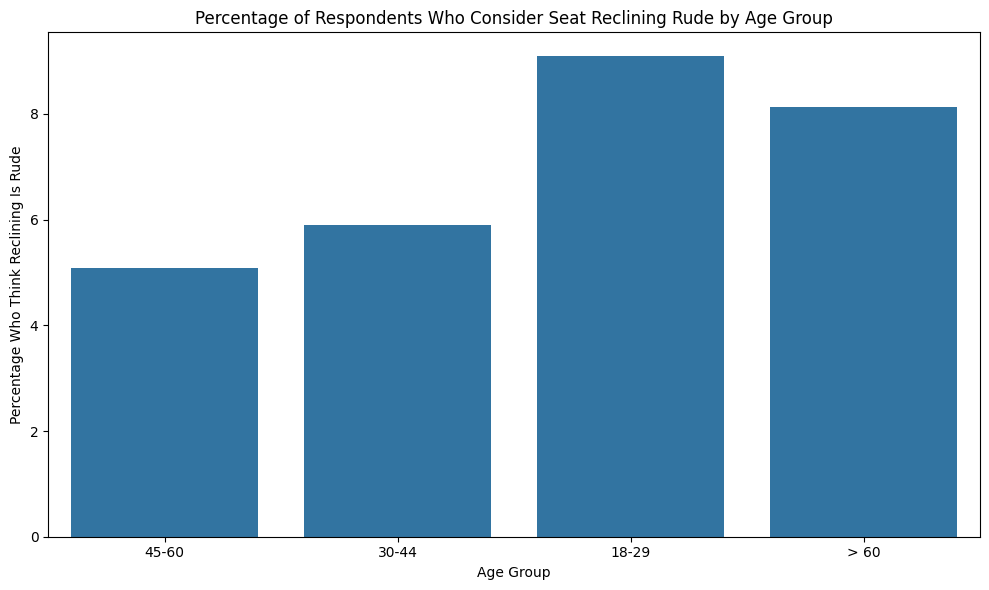

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(
    data=pdf,
    x="age",
    y="percentage_very_rude"
)

plt.xlabel("Age Group")
plt.ylabel("Percentage Who Think Reclining Is Rude")
plt.title("Percentage of Respondents Who Consider Seat Reclining Rude by Age Group")

plt.tight_layout()
plt.show()


Part d) Alcohol Consumption and General Rudeness Perceptions
Consider the variables:

alcohol (answers to "Do you drink alcohol while flying?")
rude (overall perception - answers to "How often do you observe rude behavior on planes?")
Write PySpark code to:

Remove rows with null values in either variable
Calculate summary statistics (count, proportions) for each combination of alcohol consumption and perceived rudeness
Create an appropriate visualization (e.g., mosaic plot equivalent or heat map) showing the relationship
Write a brief analysis: Does alcohol consumption appear to be related to how often passengers observe rude behavior? Is there a pattern?
Include in your answer: PySpark code, summary statistics, visualization, and interpretation.

In [18]:
df_clean = spark_data.dropna(subset=["frequency", "recline_rude"])
df_clean.show(2)


+------+-----+-----------------+-------------------+-------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+-----------+
|gender|  age|children_under_18|   household_income|          frequency|  recline_frequency|recline_obligation|recline_rude|recline_eliminate|switch_seats_friends|switch_seats_family|wake_up_bathroom|wake_up_walk|    baby|unruly_child|       two_arm_rests|     middle_arm_rest|               shade|unsold_seat|talk_stranger|     get_up|
+------+-----+-----------------+-------------------+-------------------+-------------------+------------------+------------+-----------------+--------------------+-------------------+----------------+------------+--------+------------+--------------------+--------------------+--------------------+-----------+-------------+--

In [19]:
summary_counts = (
    df_clean
    .groupBy("frequency", "recline_rude")
    .count()
    .orderBy("frequency", "recline_rude")
)

summary_counts.show()


+--------------------+------------+-----+
|           frequency|recline_rude|count|
+--------------------+------------+-----+
|A few times per m...|          No|   15|
|A few times per m...|    Somewhat|    7|
|A few times per m...|        Very|    7|
|A few times per week|          No|    1|
|A few times per week|    Somewhat|    1|
|           Every day|        Very|    3|
|               Never|          NA|  164|
|Once a month or less|          No|  104|
|Once a month or less|    Somewhat|   81|
|Once a month or less|        Very|   13|
| Once a year or less|          No|  374|
| Once a year or less|    Somewhat|  190|
| Once a year or less|        Very|   47|
+--------------------+------------+-----+



In [20]:
from pyspark.sql.functions import col


totals = (
    df_clean
    .groupBy("frequency")
    .count()
    .withColumnRenamed("count", "total")
)

summary_percent = (
    summary_counts
    .join(totals, on="frequency")
    .withColumn(
        "percentage",
        (col("count") / col("total")) * 100
    )
)

summary_percent.show()


+--------------------+------------+-----+-----+------------------+
|           frequency|recline_rude|count|total|        percentage|
+--------------------+------------+-----+-----+------------------+
|Once a month or less|        Very|   13|  198| 6.565656565656567|
|A few times per m...|        Very|    7|   29|24.137931034482758|
| Once a year or less|          No|  374|  611|61.211129296235676|
|A few times per m...|    Somewhat|    7|   29|24.137931034482758|
| Once a year or less|        Very|   47|  611|7.6923076923076925|
|               Never|          NA|  164|  164|             100.0|
|A few times per m...|          No|   15|   29|51.724137931034484|
|Once a month or less|          No|  104|  198| 52.52525252525253|
|A few times per week|          No|    1|    2|              50.0|
| Once a year or less|    Somewhat|  190|  611| 31.09656301145663|
|A few times per week|    Somewhat|    1|    2|              50.0|
|           Every day|        Very|    3|    3|             10

In [21]:
pdf = summary_percent.toPandas()


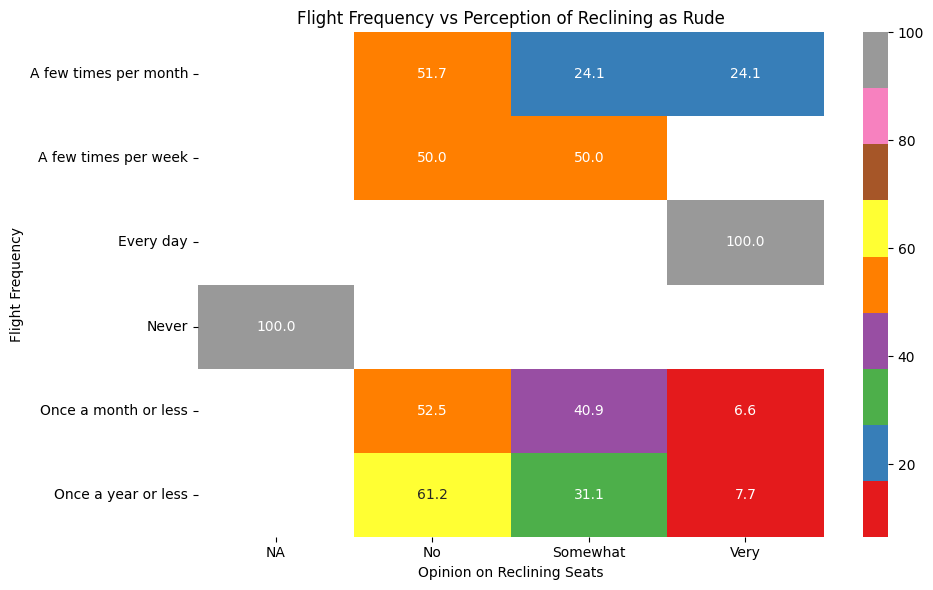

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = pdf.pivot(
    index="frequency",
    columns="recline_rude",
    values="percentage"
)

plt.figure(figsize=(10, 6))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="Set1"
)

plt.xlabel("Opinion on Reclining Seats")
plt.ylabel("Flight Frequency")
plt.title("Flight Frequency vs Perception of Reclining as Rude")

plt.tight_layout()
plt.show()
